In [1]:
import os
import json
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader,random_split
import pickle
from PIL import Image, ImageDraw
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
import torch.nn as nn
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.patches as patches


C:\Users\pavan\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class RefCOCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, refexp_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # Load the COCO annotations
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        # Load the referring expressions from .p file
        with open(refexp_file, 'rb') as f:
            self.referring_expressions = pickle.load(f)

        # Create mappings
        self.image_id_to_info = {img['id']: img for img in self.coco_data['images']}
        self.ann_id_to_info = {ann['id']: ann for ann in self.coco_data['annotations']}

        # Collect data points
        self.data = []
        for ref in self.referring_expressions:
            ann = self.ann_id_to_info[ref['ann_id']]
            img_info = self.image_id_to_info[ref['image_id']]
            for sentence in ref['sentences']:
                self.data.append({
                    'image_id': img_info['id'],
                    'file_name': img_info['file_name'],
                    'bbox': ann['bbox'],
                    'caption': sentence['raw']
                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Load image
        img_path = os.path.join(self.image_dir, sample['file_name'])
        image = Image.open(img_path).convert('RGB')

        # Get original bounding box [x_min, y_min, width, height]
        bbox = sample['bbox']
        original_width, original_height = image.size

        # Scale bounding box to 224x224
        x_min, y_min, width, height = bbox
        x_min = (x_min / original_width) * 224
        y_min = (y_min / original_height) * 224
        width = (width / original_width) * 224
        height = (height / original_height) * 224

        scaled_bbox = [x_min, y_min, x_min + width, y_min + height]  # Convert to [x_min, y_min, x_max, y_max]

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'bbox': torch.tensor(scaled_bbox, dtype=torch.float32),
            'caption': sample['caption']
        }



In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])
denormalize = transforms.Compose([
    transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                         std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
])

In [4]:
def visualize_sample(sample):
    """
    Visualize a sample by drawing the bounding box on the image and displaying it.

    Args:
        sample (dict): A dictionary with keys:
                       - 'image': Tensor of the image (normalized).
                       - 'bbox': Bounding box [x, y, width, height].
                       - 'caption': Caption describing the image.
    """
    # Denormalize the image tensor
    denormalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                             std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
    ])
    
    image_tensor = sample['image']
    denormalized_image = denormalize(image_tensor)

    # Clamp values to the range [0, 1]
    denormalized_image = torch.clamp(denormalized_image, 0, 1)

    # Convert the denormalized tensor back to a PIL image
    image = transforms.ToPILImage()(denormalized_image).convert("RGB")

    # Extract the bounding box and caption
    bbox = sample['bbox']
    captions = sample['caption']

    # Draw the bounding box
    draw = ImageDraw.Draw(image)
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], outline="red", width=3)

    # Display the image with the bounding box
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(f"Captions: {captions}")
    plt.show()


In [ ]:

class VisualGroundingModel(nn.Module):
    def __init__(self, hidden_dim=512, num_decoder_layers=3):
        super(VisualGroundingModel, self).__init__()

        # Image Encoder: Pre-trained MobileNetV3
        mobilenet = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        self.image_encoder = mobilenet.features  # Extract feature layers

        # Project MobileNetV3 output channels (960) to hidden_dim with non-linearity
        self.image_proj = nn.Sequential(
            nn.Conv2d(960, hidden_dim, kernel_size=1),
            nn.ReLU()
        )

        # Text Encoder: Pre-trained BERT
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')

        # Freeze all layers initially
        for param in self.text_encoder.parameters():
            param.requires_grad = False

        # Unfreeze the last 3 layers of BERT
        for layer in self.text_encoder.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

        self.text_proj = nn.Linear(self.text_encoder.config.hidden_size, hidden_dim)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_dim, nhead=8)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, hidden_dim, 256))  # Max 256 positions

        # Bounding Box Prediction Head
        self.bbox_head = nn.Linear(hidden_dim, 4)

    def forward(self, image, text_input_ids, text_attention_mask):
        # Image features
        image_features = self.image_encoder(image)  # Shape: [B, 960, H, W]
        image_features = self.image_proj(image_features)  # Shape: [B, hidden_dim, H, W]
        B, C, H, W = image_features.shape
        image_features = image_features.flatten(2).permute(2, 0, 1)  # Shape: [H*W, B, hidden_dim]

        # Add positional encoding to image features
        pos_enc = self.positional_encoding[:, :, :H*W].to(image_features.device)
        image_features = image_features + pos_enc.permute(2, 0, 1)  # Shape: [H*W, B, hidden_dim]

        # Text features
        text_outputs = self.text_encoder(input_ids=text_input_ids, attention_mask=text_attention_mask)
        text_features = text_outputs.last_hidden_state.permute(1, 0, 2)  # Shape: [L, B, hidden_dim]
        text_features = self.text_proj(text_features)

        # Decode: Text features as queries, image features as context
        decoder_output = self.decoder(text_features, image_features)  # Shape: [L, B, hidden_dim]

        # Attention weights for aggregation
        attn_weights = torch.softmax(decoder_output, dim=0)  # Shape: [L, B, hidden_dim]
        weighted_output = (attn_weights * decoder_output).sum(dim=0)  # Shape: [B, hidden_dim]

        # Bounding box prediction
        bbox = self.bbox_head(weighted_output)  # Shape: [B, 4]

        return bbox


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v2
from transformers import DistilBertModel

class ReferringGroundingModel(nn.Module):
    def __init__(self, cnn_out_dim=256, text_out_dim=256):
        super().__init__()

        # 1. Visual Encoder (CNN backbone)
        self.cnn = mobilenet_v2(pretrained=True).features
        self.conv_proj = nn.Conv2d(1280, cnn_out_dim, kernel_size=1)  # Final MobileNet layer output

        # 2. Text Encoder
        self.text_encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.text_proj = nn.Linear(768, text_out_dim)

        # 3. Heatmap head
        self.heatmap_conv = nn.Sequential(
            nn.Conv2d(cnn_out_dim + text_out_dim, 256, 1),
            nn.ReLU(),
            nn.Conv2d(256, 1, 1)
        )

        # 4. Box size regressor (from center feature)
        self.box_mlp = nn.Sequential(
            nn.Linear(cnn_out_dim + text_out_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2),  # (w, h)
        )

    def forward(self, image, input_ids, attention_mask):
        B = image.size(0)

        # CNN
        x = self.cnn(image)             # [B, 1280, 7, 7]
        x = self.conv_proj(x)          # [B, C, 7, 7]

        # Text encoder
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_feat = text_outputs.last_hidden_state[:, 0, :]  # [B, 768]
        text_feat = self.text_proj(text_feat)                # [B, D]

        # Broadcast text
        text_feat = text_feat.unsqueeze(-1).unsqueeze(-1)    # [B, D, 1, 1]
        text_feat = text_feat.expand(-1, -1, x.size(2), x.size(3))  # [B, D, H, W]

        # Fuse
        fused = torch.cat([x, text_feat], dim=1)  # [B, C+D, H, W]

        # Heatmap
        heatmap = self.heatmap_conv(fused).squeeze(1)  # [B, H, W]

        # Soft-argmax to get (cx, cy)
        prob = heatmap.view(B, -1)
        prob = F.softmax(prob, dim=-1)
        grid = self._make_grid(x.shape[2], x.shape[3], image.device)  # [H*W, 2]
        coords = torch.matmul(prob, grid)  # [B, 2] → (cx, cy) in feature space

        # Sample fused feature at (cx, cy)
        cx_norm = coords[:, 0] / (x.shape[3] - 1) * 2 - 1
        cy_norm = coords[:, 1] / (x.shape[2] - 1) * 2 - 1
        grid_coords = torch.stack([cx_norm, cy_norm], dim=1).unsqueeze(1).unsqueeze(1)  # [B,1,1,2]

        sampled_feat = F.grid_sample(fused, grid_coords, align_corners=True)  # [B, C+D, 1, 1]
        sampled_feat = sampled_feat.view(B, -1)  # [B, C+D]

        wh = self.box_mlp(sampled_feat)         # [B, 2]
        cx, cy = coords[:, 0], coords[:, 1]

        # Convert to pixel scale
        scale = image.size(2) // x.size(2)  # Usually 224//7 = 32
        cx = cx * scale
        cy = cy * scale
        w, h = wh[:, 0] * scale, wh[:, 1] * scale

        x1 = cx - w / 2
        y1 = cy - h / 2
        x2 = cx + w / 2
        y2 = cy + h / 2

        boxes = torch.stack([x1, y1, x2, y2], dim=1)  # [B, 4]
        return boxes, heatmap

    def _make_grid(self, H, W, device):
        y = torch.arange(H, device=device).float()
        x = torch.arange(W, device=device).float()
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        grid = torch.stack([grid_x, grid_y], dim=-1).view(-1, 2)  # [H*W, 2]
        return grid


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
image_dir = 'train2014'
# val_image_dir = './coco/coco2014/images/val2014'
annotation_file = './refcoco/instances.json'
refexp_file = './refcoco/refs(unc).p'

In [11]:
full_dataset = RefCOCODataset(image_dir, annotation_file, refexp_file, transform=transform)
train_size = int(0.93 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [12]:
print(f'training instances: {len(train_dataset)}')
print(f'val instances: {len(val_dataset)}')

training instances: 132255
val instances: 9955


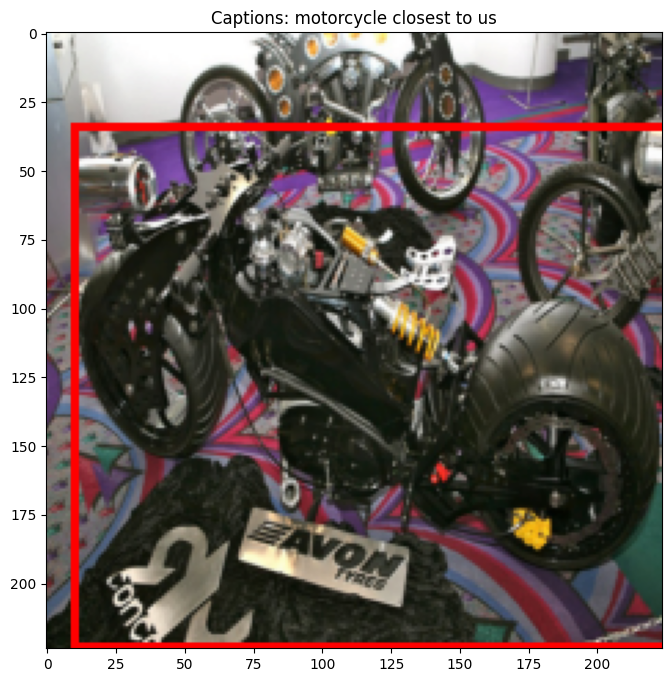

In [13]:
visualize_sample(val_dataset[2])

In [14]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [15]:
model = ReferringGroundingModel()
model = model.to(device)

C:\Users\pavan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pavan\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\pavan/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 22.1MB/s]


In [ ]:
# model.load_state_dict(torch.load('visual_grounding_model.pth',weights_only=True))

In [21]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


In [18]:
bbox_loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
train_batch_losses = []
val_batch_losses = []
train_epoch_loss = []
val_epoch_loss = []

In [22]:
num_epochs = 50
print_every = 1000
save_path = 'visual_grounding_model.pth'

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for batch_idx, batch in enumerate(progress_bar):
        images = batch['image'].to(device)       # [B, 3, 224, 224]
        bboxes = batch['bbox'].to(device)        # [B, 4]
        captions = batch['caption']

        # Tokenize captions
        encoding = tokenizer(captions, return_tensors='pt', padding=True, truncation=True)
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Forward pass
        optimizer.zero_grad()
        predicted_bboxes, _ = model(images, input_ids, attention_mask)

        # Compute loss
        loss = bbox_loss_fn(predicted_bboxes, bboxes)

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()
        train_batch_losses.append(loss.item())

        # Print every 'print_every' batches
        if (batch_idx + 1) % print_every == 0:
            avg_loss = epoch_loss / (batch_idx + 1)
            print(f"Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {avg_loss:.4f}")

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Completed. Average Loss: {avg_epoch_loss:.4f}")
    train_epoch_loss.append(avg_epoch_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            images = batch['image'].to(device)
            bboxes = batch['bbox'].to(device)
            captions = batch['caption']

            # Tokenize captions
            encoding = tokenizer(captions, return_tensors='pt', padding=True, truncation=True)
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            # Forward pass
            predicted_bboxes, _ = model(images, input_ids, attention_mask)

            # Compute loss
            loss = bbox_loss_fn(predicted_bboxes, bboxes)
            val_loss += loss.item()
            val_batch_losses.append(loss.item())

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    val_epoch_loss.append(avg_val_loss)

    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

print("Training completed!")


Epoch 1/50:  74%|███████▎  | 760/1034 [1:15:00<27:02,  5.92s/it, loss=30.6]


KeyboardInterrupt: 

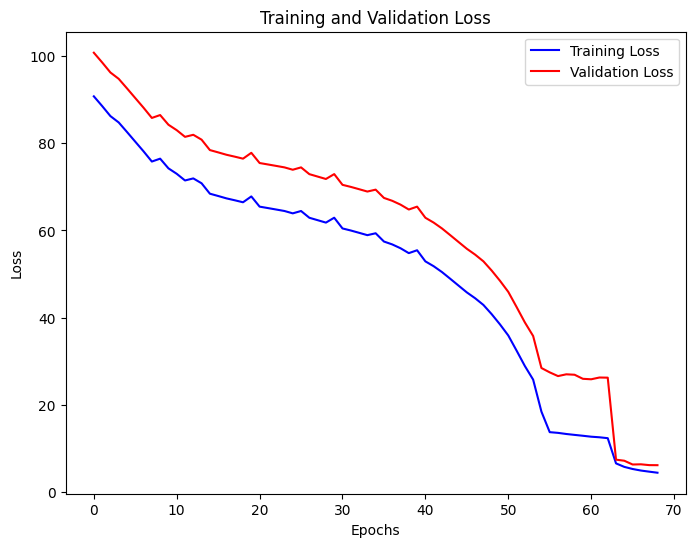

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_epoch_loss, label='Training Loss', color='b')
plt.plot(val_epoch_loss, label='Validation Loss', color='r')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [197]:
def calculate_iou(pred_box, gt_box):
    """
    Calculate Intersection over Union (IoU) for a single pair of predicted and ground-truth bounding boxes.
    
    Args:
        pred_box: Tensor of shape [4], predicted bounding box [x1, y1, x2, y2]
        gt_box: Tensor of shape [4], ground-truth bounding box [x1, y1, x2, y2]
    
    Returns:
        IoU: Intersection over Union score
    """
    # Calculate coordinates of intersection rectangle
    x1 = max(pred_box[0], gt_box[0])
    y1 = max(pred_box[1], gt_box[1])
    x2 = min(pred_box[2], gt_box[2])
    y2 = min(pred_box[3], gt_box[3])
    
    # Calculate intersection area
    inter_width = max(0, x2 - x1)
    inter_height = max(0, y2 - y1)
    intersection = inter_width * inter_height
    
    # Calculate areas of both bounding boxes
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    
    # Calculate union area
    union = pred_area + gt_area - intersection
    
    # Avoid division by zero
    if union == 0:
        return 0.0
    
    return intersection / union

# Function to calculate mAP for the validation set
def calculate_map(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Calculate Mean Average Precision (mAP) for a batch of predicted and ground-truth bounding boxes.
    
    Args:
        pred_boxes: List of predicted bounding boxes, each of shape [4]
        gt_boxes: List of ground-truth bounding boxes, each of shape [4]
        iou_threshold: IoU threshold to consider a prediction as a True Positive
    
    Returns:
        mAP: Mean Average Precision score
    """
    assert len(pred_boxes) == len(gt_boxes), "Predicted and ground-truth boxes must have the same length"
    
    tp = 0  # True Positives
    fp = 0  # False Positives
    
    for pred_box, gt_box in zip(pred_boxes, gt_boxes):
        iou = calculate_iou(pred_box, gt_box)
        if iou >= iou_threshold:
            tp += 1
        else:
            fp += 1
    
    # Precision calculation
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / len(gt_boxes) if len(gt_boxes) > 0 else 0
    
    return precision, recall

In [198]:
# Validation loop with IoU and mAP calculation
model.eval()
val_loss = 0.0
all_pred_boxes = []
all_gt_boxes = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        images = batch['image'].to(device)
        bboxes = batch['bbox'].to(device)
        captions = batch['caption']

        # Tokenize captions
        encoding = tokenizer(captions, return_tensors='pt', padding=True, truncation=True)
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # Forward pass
        predicted_bboxes = model(images, input_ids, attention_mask)

        # Compute loss
        loss = bbox_loss_fn(predicted_bboxes, bboxes)
        val_loss += loss.item()

        # Store predicted and ground-truth boxes for IoU and mAP calculation
        all_pred_boxes.extend(predicted_bboxes.cpu())
        all_gt_boxes.extend(bboxes.cpu())

avg_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss:.4f}")

# Calculate mAP and average IoU
precisions, recalls = [], []
ious = []

for pred_box, gt_box in zip(all_pred_boxes, all_gt_boxes):
    iou = calculate_iou(pred_box, gt_box)
    ious.append(iou)
    precision, recall = calculate_map([pred_box], [gt_box], iou_threshold=0.5)
    precisions.append(precision)
    recalls.append(recall)

avg_iou = sum(ious) / len(ious)
mean_precision = sum(precisions) / len(precisions)
mean_recall = sum(recalls) / len(recalls)

print(f"Average IoU: {avg_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")


Validating: 100%|██████████| 78/78 [00:44<00:00,  1.74it/s]


Validation Loss: 5.9673
Average IoU: 0.7559
Mean Precision: 0.9230
Mean Recall: 0.9230


In [87]:
sample = val_dataset[5]

In [214]:


def infer_and_plot(image_tensor, caption, model, tokenizer, device, ground_truth_bbox):
    """
    Perform inference on a single preprocessed image tensor and caption, then plot the image 
    with the predicted and ground truth bounding boxes.

    Args:
        image_tensor (torch.Tensor): Preprocessed image tensor of shape [3, 224, 224].
        caption (str): Caption describing the object in the image.
        model (torch.nn.Module): Trained visual grounding model.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for the captions.
        device (torch.device): Device (CPU or GPU) to run inference on.
        ground_truth_bbox (list or tuple): Ground truth bounding box [x_min, y_min, x_max, y_max].
    """
    # Move the image tensor to the specified device and add batch dimension if needed
    image_tensor = image_tensor.unsqueeze(0).to(device) if image_tensor.dim() == 3 else image_tensor.to(device)

    # Tokenize the caption
    encoding = tokenizer([caption], return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        predicted_bboxes = model(image_tensor, input_ids, attention_mask)

    # Extract the predicted bounding box
    predicted_bbox = predicted_bboxes[0].cpu().numpy()  # Assuming the output is [B, 4]

    # Bounding box coordinates for the 224x224 image
    pred_x_min, pred_y_min, pred_x_max, pred_y_max = predicted_bbox
    gt_x_min, gt_y_min, gt_x_max, gt_y_max = ground_truth_bbox

    # Denormalize the image if necessary
    denormalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                             std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
    ])
    denormalized_image = denormalize(image_tensor.squeeze(0).cpu())
    denormalized_image = torch.clamp(denormalized_image, 0, 1)

    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(denormalized_image.permute(1, 2, 0))  # Convert tensor to image format for plotting

    # Ground truth bounding box (Green)
    gt_rect = patches.Rectangle(
        (gt_x_min, gt_y_min),
        gt_x_max - gt_x_min,
        gt_y_max - gt_y_min,
        linewidth=2,
        edgecolor='green',
        facecolor='none',
        label='Ground Truth'
    )

    # Predicted bounding box (Red)
    pred_rect = patches.Rectangle(
        (pred_x_min, pred_y_min),
        pred_x_max - pred_x_min,
        pred_y_max - pred_y_min,
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        label='Predicted'
    )

    # Add rectangles to the plot
    ax.add_patch(gt_rect)
    ax.add_patch(pred_rect)

    # Add legend and title
    plt.legend(loc='upper right')
    plt.title(f"Caption: {caption}")

    # Show the plot
    plt.show()


In [215]:
sample = val_dataset[290]

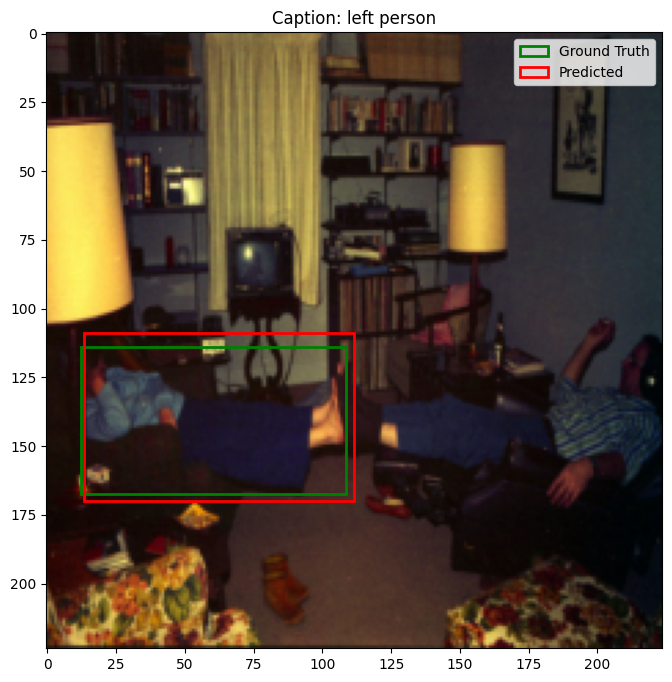

In [216]:
infer_and_plot(sample['image'], sample['caption'], model, tokenizer, device,sample['bbox'])

In [217]:
pip list > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
!wget http://images.cocodataset.org/zips/train2014.zip 

'wget' is not recognized as an internal or external command,
operable program or batch file.
